# Segmentasi Susu Habis - All Channel

## Outline

    [x] Data diambil dari database untuk brand A
    [] Filter
        [x] All channel
    [x] Gramasi >=340
    [x] Boleh terkena campaign kembali setelah  >14 hari dari last campaign
    [x] Segment ditarik 2x seminggu
        
    [x] Split for treatment and control group
        [] Treatment Email (90%) -- user yang hanya memiliki email dan gramasi >= 800 gr
           Konten A (50%)
           Konten B (50%)
        [] Control Email (10%)
        [] Treatment WA (90%) -- user yang hanya memiliki nomorhandphone 
           Konten A (50%)
           Konten B (50%)
        [] Control WA (10%)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pyodbc #untuk connect sql 
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [2]:
# Konfigurasi koneksi ke SQL Server
server = 'server'
database = 'database'
username = 'username'
password = 'password'
# Buat koneksi
connection = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

In [3]:
# Contoh eksekusi pernyataan SQL dan ubah hasilnya menjadi tabel
query = """
WITH CTE1 AS(
	SELECT kontakid, contactname,
		purchaseddate last_purchaseddate, SUM(netweight) gramasi,
		DATEADD(DAY, (ROUND(SUM(netweight)/58.33,0)), purchaseddate) tanggal_susuhabis, --- 58.33 adalah hasil eksplorasi
		LEFT(nomorhandphone, 4) + REPLICATE('X', (LEN(nomorhandphone)-4)) nomorhandphone, 
		LEFT(email, 4) + REPLICATE('X', (LEN(email)-14)) + RIGHT(email, 10) email,
		ROW_NUMBER() OVER (PARTITION BY kontakid ORDER BY purchaseddate DESC) row_num,
		GETDATE() AS tglupdate 
	FROM Tabel1 WITH(NOLOCK)
	WHERE PurchasedDate >= DATEADD(DAY, -180, GETDATE()) --- transaksi 3 bulan terakhir
		AND Brand = 'A'
	GROUP BY kontakid,ContactName, purchaseddate,  nomorhandphone , email,product
	),
CTE2 AS(
	SELECT DISTINCT kontakid AS kontak, MAX(created_date) created_date
	FROM Tabel2 WITH(NOLOCK)
	GROUP BY kontakid
	)

SELECT *
FROM
	(
	SELECT *, 
		CASE WHEN LEFT(nomorhandphone, 2) = '08' THEN '+628' + RIGHT(nomorhandphone, LEN(nomorhandphone) - 2)
			ELSE nomorhandphone END AS nomorhandphone_v2,
		ROW_NUMBER() OVER (PARTITION BY nomorhandphone ORDER BY kontakid) rank_nohp
	FROM CTE1 LEFT JOIN CTE2 ON CTE1.kontakid = CTE2.kontak
	WHERE row_num = 1 AND (CTE2.kontak IS NULL OR created_date <  DATEADD(DAY, -15, GETDATE()))
		AND gramasi >= 340
		AND ((DATEPART(WEEKDAY, GETDATE()) = 2 AND DATEDIFF(DAY, GETDATE() , tanggal_susuhabis) BETWEEN 0 AND 2)  -- Senin
		OR (DATEPART(WEEKDAY, GETDATE()) = 5 AND DATEDIFF(DAY, GETDATE() , tanggal_susuhabis)  BETWEEN 0 AND 3)) -- Kamis
	)Data
WHERE rank_nohp = 1
"""


In [4]:
data_raw= pd.read_sql(query, connection)

In [5]:
#menutup koneksi 
connection.close()

In [6]:
# Menampilkan tabel dengan format yang lebih baik
#display(data_raw)
data_raw.head(3)

kontakid         contactname last_purchaseddate  gramasi  \
0  2305-CRM65D2          IVANA DEWI         2024-02-17      400   
1  0706-0194695          YENI RISKA         2024-02-08      800   
2  0811-8895786  M UMAR WAHAB LUBIS         2024-02-10      700   

  tanggal_susuhabis nomorhandphone email  row_num               tglupdate  \
0        2024-02-24   0811XXXXXXXX  None        1 2024-02-22 11:33:59.507   
1        2024-02-22    0812XXXXXXX  None        1 2024-02-22 11:33:59.507   
2        2024-02-22   0812XXXXXXXX  None        1 2024-02-22 11:33:59.507   

  nomorhandphone_v2  rank_nohp  
0    +62811XXXXXXXX          1  
1     +62812XXXXXXX          1  
2    +62812XXXXXXXX          1

In [7]:
cols = ["kontakid","contactname","email", "nomorhandphone","nomorhandphone_v2","tanggal_susuhabis"]
data_raw["last_purchaseddate"] = pd.to_datetime(data_raw["last_purchaseddate"]) #buat rubah format datetime 

In [8]:
data_raw[cols].head() # buat pilih kolom tertentu 

kontakid         contactname email nomorhandphone nomorhandphone_v2  \
0  2305-CRM65D2          IVANA DEWI  None   0811XXXXXXXX    +62811XXXXXXXX   
1  0706-0194695          YENI RISKA  None    0812XXXXXXX     +62812XXXXXXX   
2  0811-8895786  M UMAR WAHAB LUBIS  None   0812XXXXXXXX    +62812XXXXXXXX   
3  1703-5313323       AGUSTINA RINI  None  0812XXXXXXXXX   +62812XXXXXXXXX   
4  0706-0369223            PUSPITA   None   0815XXXXXXXX    +62815XXXXXXXX   

  tanggal_susuhabis  
0        2024-02-24  
1        2024-02-22  
2        2024-02-22  
3        2024-02-25  
4        2024-02-24

In [9]:
#Melihat jumlah baris dan kolom 
data_raw.shape

(79, 11)

In [10]:
#untuk melihat max date 
data=data_raw
max_date  = data.last_purchaseddate.max()
print(max_date)

2024-02-18 00:00:00


In [11]:
count_gramasi_below_800 = data[data['gramasi'] < 800]['kontakid'].count()

print("Jumlah kontak dengan gramasi < 800:", count_gramasi_below_800)

Jumlah kontak dengan gramasi < 800: 26


In [12]:
data[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   kontakid           79 non-null     object
 1   contactname        78 non-null     object
 2   email              23 non-null     object
 3   nomorhandphone     78 non-null     object
 4   nomorhandphone_v2  78 non-null     object
 5   tanggal_susuhabis  79 non-null     object
dtypes: object(6)
memory usage: 3.8+ KB


In [13]:
data.groupby("gramasi")["kontakid"].nunique()

gramasi
400      15
600       6
700       4
780       1
800      26
840       1
1000      1
1200      2
1400      2
1600     16
3200      1
4800      1
6400      1
9600      1
10080     1
Name: kontakid, dtype: int64

## All Channel Days remaining 0-2 Days 


In [14]:
len(data["kontakid"].unique())

79

In [15]:
#Buat DataFrame 'emails' berdasarkan kondisi email dan gramasi >= 800
emails = data[(~data['email'].isna()) & (data['gramasi'] >= 800)]

# Buat DataFrame 'wa' berdasarkan kondisi nomor handphone dan bukan bagian dari 'emails'
wa = data[(~data['nomorhandphone'].isna()) & (~data['kontakid'].isin(emails['kontakid']))]


In [16]:
emails_kontak=emails.kontakid.unique()
wa_kontak=wa.kontakid.unique()

In [17]:
#emails.kontakid.nunique()
print("Jmlh kontakid uniq by email: ",emails.kontakid.nunique()) #jumlah kontakid by email not null dan gramasi >= 800 
print("Jmlh Kontaid uniq by wa: ",wa.kontakid.nunique()) #jumlah kontakid yang no hp tidak kosong dan gramasi < 800

Jmlh kontakid uniq by email:  16
Jmlh Kontaid uniq by wa:  62


In [18]:
control_emails_kontak = emails.sample(frac=0.1, random_state= 123) #Dalam metode .sample() dari pandas, secara default parameter replace memiliki nilai replace=False, yang berarti pengambilan sampel dilakukan tanpa pengembalian (elemen tidak akan duplikat dalam sampel).

In [19]:
control_email = control_emails_kontak[cols].drop_duplicates() #menghapus duplicate #hanya berisi 7 kolom 

In [20]:
treatment_emails_kontak = emails[~emails.kontakid.isin(control_emails_kontak.kontakid.unique())]

In [21]:
#treatment_emails_kontak.head()
print("jumlah baris dan kolom kontrol email: ",control_emails_kontak.shape) 
print("jumlah baris dan kolom email: ",treatment_emails_kontak.shape) 

jumlah baris dan kolom kontrol email:  (2, 11)
jumlah baris dan kolom email:  (14, 11)


In [22]:
# Mengambil sampel 50 : 50  untuuk kontan A dan B ,sampel tanpa pengembalian
Email_konten_a = treatment_emails_kontak.sample(frac=0.5, random_state=123)
Email_konten_b = treatment_emails_kontak[~treatment_emails_kontak.kontakid.isin(Email_konten_a.kontakid.unique())]

In [23]:
#Email_konten_b.head()

In [24]:
konten_A_Email = Email_konten_a[cols].drop_duplicates()
konten_B_Email= Email_konten_b[cols].drop_duplicates()

In [25]:
print("jumlah baris dan kolom email_Konten A: ",Email_konten_a.shape) 
print("jumlah baris dan kolom email_Konten B: ",Email_konten_b.shape) 

jumlah baris dan kolom email_Konten A:  (7, 11)
jumlah baris dan kolom email_Konten B:  (7, 11)


In [26]:
print("jumlah baris dan kolom email_Konten A: ",konten_A_Email.shape) 
print("jumlah baris dan kolom email_Konten B: ",konten_B_Email.shape) 

jumlah baris dan kolom email_Konten A:  (7, 6)
jumlah baris dan kolom email_Konten B:  (7, 6)


In [27]:
dist_Control = data[data.kontakid.isin(control_email.kontakid.unique())]
dist_Konten_A = data[data.kontakid.isin(konten_A_Email.kontakid.unique())]
dist_Konten_B = data[data.kontakid.isin(konten_B_Email.kontakid.unique())]


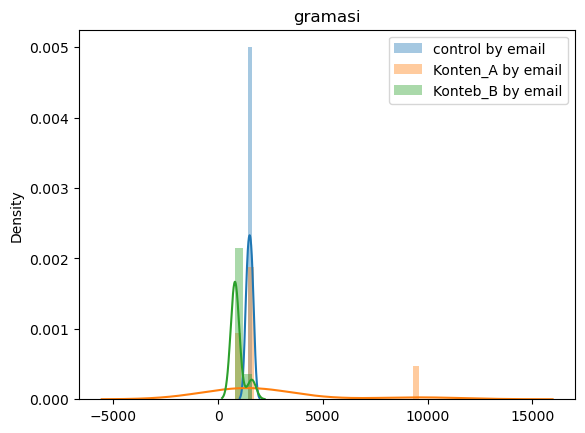

In [28]:
val = ["gramasi"]

for v in val:
    sns.distplot(dist_Control[val], label="control by email")
    sns.distplot(dist_Konten_A[val], label="Konten_A by email")
    sns.distplot(dist_Konten_B[val], label="Konteb_B by email")
    plt.title(v)
    plt.legend()
    plt.show()

In [29]:
control_wa_kontak = wa.sample(frac=0.1, random_state= 123) #Dalam metode .sample() dari pandas, secara default parameter replace memiliki nilai replace=False, yang berarti pengambilan sampel dilakukan tanpa pengembalian (elemen tidak akan duplikat dalam sampel).

In [30]:
control_wa = control_wa_kontak[cols].drop_duplicates() #menghapus duplicate #hanya berisi 7 kolom 

In [31]:
treatment_wa_kontak = wa[~wa.kontakid.isin(control_wa_kontak.kontakid.unique())]

In [32]:
#treatment_emails_kontak.head()
print("jumlah baris dan kolom kontrol WA: ",control_wa_kontak.shape) 
print("jumlah baris dan kolom WA: ",treatment_wa_kontak.shape) 

jumlah baris dan kolom kontrol WA:  (6, 11)
jumlah baris dan kolom WA:  (56, 11)


In [33]:
# Mengambil sampel 50 : 50  untuuk kontan A dan B ,sampel tanpa pengembalian
wa_konten_a = treatment_wa_kontak.sample(frac=0.5, random_state=123)
wa_konten_b = treatment_wa_kontak[~treatment_wa_kontak.kontakid.isin(wa_konten_a.kontakid.unique())]

In [34]:
konten_A_wa = wa_konten_a[cols].drop_duplicates()
konten_B_wa= wa_konten_b[cols].drop_duplicates()

In [35]:
print("jumlah baris dan kolom WA_Konten A: ",wa_konten_a.shape) 
print("jumlah baris dan kolom WA_Konten B: ",wa_konten_b.shape) 

jumlah baris dan kolom WA_Konten A:  (28, 11)
jumlah baris dan kolom WA_Konten B:  (28, 11)


In [36]:
print("jumlah baris dan kolom wa_Konten A: ",konten_A_wa.shape) 
print("jumlah baris dan kolom wa_Konten B: ",konten_B_wa.shape) 

jumlah baris dan kolom wa_Konten A:  (28, 6)
jumlah baris dan kolom wa_Konten B:  (28, 6)


In [37]:
dist_Control_wa = data[data.kontakid.isin(control_wa.kontakid.unique())]
dist_Konten_A_wa = data[data.kontakid.isin(konten_A_wa.kontakid.unique())]
dist_Konten_B_wa = data[data.kontakid.isin(konten_B_wa.kontakid.unique())]


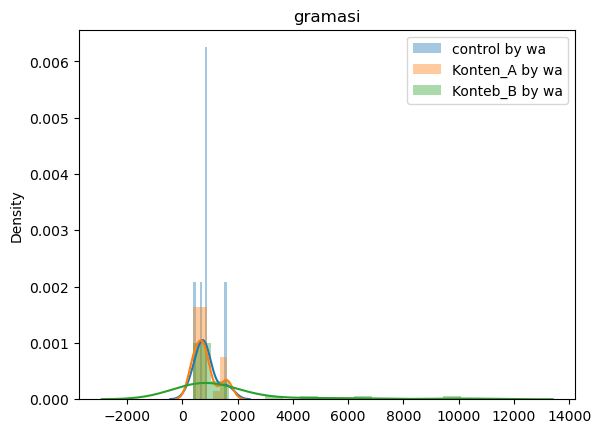

In [38]:
val = ["gramasi"]

for v in val:
    sns.distplot(dist_Control_wa[val], label="control by wa")
    sns.distplot(dist_Konten_A_wa[val], label="Konten_A by wa")
    sns.distplot(dist_Konten_B_wa[val], label="Konteb_B by wa")
    plt.title(v)
    plt.legend()
    plt.show()

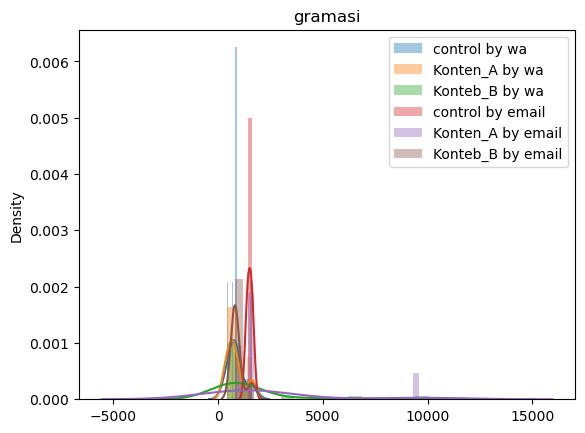

In [39]:
val = ["gramasi"]

for v in val:
    sns.distplot(dist_Control_wa[val], label="control by wa")
    sns.distplot(dist_Konten_A_wa[val], label="Konten_A by wa")
    sns.distplot(dist_Konten_B_wa[val], label="Konteb_B by wa")
    sns.distplot(dist_Control[val], label="control by email")
    sns.distplot(dist_Konten_A[val], label="Konten_A by email")
    sns.distplot(dist_Konten_B[val], label="Konteb_B by email")
    plt.title(v)
    plt.legend()
    plt.show()

# Summary Notebook

In [40]:
#treatment_emails_kontak.head()
#emails.kontakid.nunique()
print("Jmlh kontakid uniq by email: ",emails.kontakid.nunique()) #jumlah kontakid by email not null dan gramasi >= 800 
print("Jmlh Kontaid uniq by wa: ",wa.kontakid.nunique()) #jumlah kontakid yang no hp tidak kosong dan gramasi < 800


Jmlh kontakid uniq by email:  16
Jmlh Kontaid uniq by wa:  62


In [41]:
print("jumlah baris dan kolom kontrol WA: ",control_wa_kontak.shape) 
print("jumlah baris dan kolom WA: ",treatment_wa_kontak.shape) 
print("jumlah baris dan kolom wa_Konten A: ",konten_A_wa.shape) 
print("jumlah baris dan kolom wa_Konten B: ",konten_B_wa.shape) 

jumlah baris dan kolom kontrol WA:  (6, 11)
jumlah baris dan kolom WA:  (56, 11)
jumlah baris dan kolom wa_Konten A:  (28, 6)
jumlah baris dan kolom wa_Konten B:  (28, 6)


In [49]:
konten_A_Email['Segmen'] = 'ma_produkhabis_kontena_email_A_202402'
konten_B_Email['Segmen'] = 'ma_produkhabis_kontenb_email_A_202402'
control_email['Segmen'] = 'ma_produkhabis_control_email_A_202402'
konten_A_wa['Segmen'] = 'ma_produkhabis_kontena_wa_A_202402'
konten_B_wa['Segmen'] = 'ma_produkhabis_kontenb_wa_A_202402'
control_wa['Segmen'] = 'ma_produkhabis_control_wa_A_202402'

In [50]:
import datetime

# Mendapatkan tanggal hari ini
tanggal_hari_ini = datetime.date.today()

# Mengganti tanggal_blast dengan tanggal hari ini
tanggal_blast = tanggal_hari_ini.strftime('%Y-%m-%d')
konten_A_Email['created_date'] = tanggal_blast
konten_B_Email['created_date'] = tanggal_blast
control_email['created_date'] = tanggal_blast
konten_A_wa['created_date'] = tanggal_blast
konten_B_wa['created_date'] = tanggal_blast
control_wa['created_date'] = tanggal_blast

In [51]:
konten_A_Email['namacampaign'] = 'Produk Habis'
konten_B_Email['namacampaign'] = 'Produk Habis'
control_email['namacampaign'] = 'Produk Habis'
konten_A_wa['namacampaign'] = 'Produk Habis'
konten_B_wa['namacampaign'] = 'Produk Habis'
control_wa['namacampaign'] = 'Produk Habis'

In [52]:
konten_A_Email['groupsegmen'] = 'Treatment'
konten_B_Email['groupsegmen'] = 'Treatment'
control_email['groupsegmen'] = 'Control'
konten_A_wa['groupsegmen'] = 'Treatment'
konten_B_wa['groupsegmen'] = 'Treatment'
control_wa['groupsegmen'] = 'Control'

In [53]:
konten_A_Email['productcategory'] = 'A'
konten_B_Email['productcategory'] = 'A'
konten_B_Email['productcategory'] = 'A'
control_email['productcategory'] = 'A'
konten_A_wa['productcategory'] = 'A'
konten_B_wa['productcategory'] = 'A'
control_wa['productcategory'] = 'A'

In [54]:
# Menggabungkan kedua DataFrame
#import pandas as pd

# Menyatukan semua tabel berdasarkan segmen
all_data = pd.concat([konten_A_Email, konten_B_Email, control_email,
                      konten_A_wa, konten_B_wa, control_wa], ignore_index=True)

all_data.head()

kontakid contactname                      email nomorhandphone  \
0  1105-1753503        ENI   ratuXXXXXXXXXXX@gmail.com     0817XXXXXX   
1  1803-DE13008       WENY   weniXXXXXXXXXXX@gmail.com  0895XXXXXXXXX   
2  2207-TDA1440        ADI             adi7X@gmail.com  0881XXXXXXXXX   
3  1411-3949568  UUN YUNITA  stevXXXXXXXXXXXutlook.com    0888XXXXXXX   
4  1906-PW08562        NIA    niayXXXXXXXXXX@gmail.com   0882XXXXXXXX   

  nomorhandphone_v2 tanggal_susuhabis                                 Segmen  \
0      +62817XXXXXX        2024-02-23  ma_produkhabis_kontena_email_A_202402   
1   +62895XXXXXXXXX        2024-02-22  ma_produkhabis_kontena_email_A_202402   
2   +62881XXXXXXXXX        2024-02-23  ma_produkhabis_kontena_email_A_202402   
3     +62888XXXXXXX        2024-02-24  ma_produkhabis_kontena_email_A_202402   
4    +62882XXXXXXXX        2024-02-23  ma_produkhabis_kontena_email_A_202402   

  created_date  namacampaign groupsegmen productcategory  
0   2024-02-22  Produk Habis   Treatment               A  
1   2024-02-22  Produk Habis   Treatment               A  
2   2024-02-22  Produk Habis   Treatment               A  
3   2024-02-22  Produk Habis   Treatment               A  
4   2024-02-22  Produk Habis   Treatment               A

In [55]:
all_data1=all_data
all_data1['email']=all_data['email'].str.strip()
all_data1['contactname'] = all_data1['contactname'].str.replace(r',.*$', '', regex=True)

all_data1.head()

kontakid contactname                      email nomorhandphone  \
0  1105-1753503        ENI   ratuXXXXXXXXXXX@gmail.com     0817XXXXXX   
1  1803-DE13008       WENY   weniXXXXXXXXXXX@gmail.com  0895XXXXXXXXX   
2  2207-TDA1440        ADI             adi7X@gmail.com  0881XXXXXXXXX   
3  1411-3949568  UUN YUNITA  stevXXXXXXXXXXXutlook.com    0888XXXXXXX   
4  1906-PW08562        NIA    niayXXXXXXXXXX@gmail.com   0882XXXXXXXX   

  nomorhandphone_v2 tanggal_susuhabis                                 Segmen  \
0      +62817XXXXXX        2024-02-23  ma_produkhabis_kontena_email_A_202402   
1   +62895XXXXXXXXX        2024-02-22  ma_produkhabis_kontena_email_A_202402   
2   +62881XXXXXXXXX        2024-02-23  ma_produkhabis_kontena_email_A_202402   
3     +62888XXXXXXX        2024-02-24  ma_produkhabis_kontena_email_A_202402   
4    +62882XXXXXXXX        2024-02-23  ma_produkhabis_kontena_email_A_202402   

  created_date  namacampaign groupsegmen productcategory  
0   2024-02-22  Produk Habis   Treatment               A  
1   2024-02-22  Produk Habis   Treatment               A  
2   2024-02-22  Produk Habis   Treatment               A  
3   2024-02-22  Produk Habis   Treatment               A  
4   2024-02-22  Produk Habis   Treatment               A